# Libraries

In [31]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

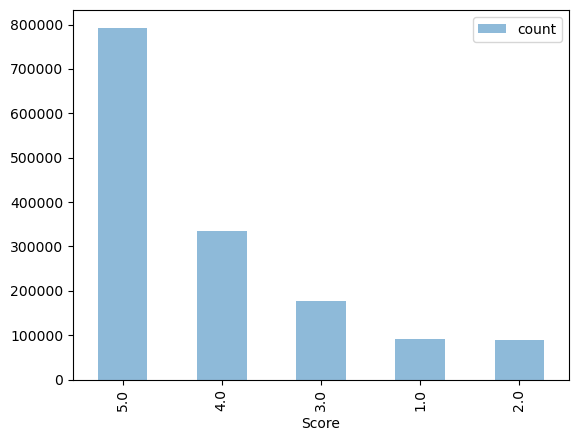


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [32]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [33]:
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

def add_features_to(df):
    # Define positive and negative words
    print("Columns in df:", df.columns)
    
    # Check if 'Review' or any potential text column exists
    text_column = 'Review' if 'Review' in df.columns else 'Text'
    if text_column not in df.columns:
        raise KeyError(f"The column '{text_column}' is missing from the DataFrame.")

    # Convert all entries in the text column to strings to avoid issues with floats
    df[text_column] = df[text_column].fillna("").astype(str)
    sid = SentimentIntensityAnalyzer()

    positive_words = [
        "good", "great", "excellent", "amazing", "love", "wonderful", 
        "fantastic", "best", "awesome", "enjoy", "perfect", "satisfy", "happy"
    ]
    negative_words = [
        "bad", "terrible", "awful", "worst", "disappoint", "poor", 
        "hate", "horrible", "annoying", "negative", "sad", "angry", "boring"
    ]
    
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Length of the review summary (simple length metric)
    df['summary_length'] = df['Summary'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    
    # Length of the full review (simple length metric)
    df['review_length'] = df['Text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    
    # Ratio of summary length to review length (to capture verbosity or conciseness)
    df['summary_review_ratio'] = df.apply(
        lambda x: x['summary_length'] / x['review_length'] if x['review_length'] > 0 else 0,
        axis=1)

    # New Feature: Word Count in Review Text
    df['review_word_count'] = df['Text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    
    # New Features: Positive and Negative Word Ratios
    def count_words(text, word_list):
        words = re.findall(r'\b\w+\b', str(text).lower())  # tokenize text to words
        return sum(1 for word in words if word in word_list)

    # Calculate positive and negative word counts
    df['positive_word_count'] = df['Text'].apply(lambda x: count_words(x, positive_words))
    df['negative_word_count'] = df['Text'].apply(lambda x: count_words(x, negative_words))

    # Calculate positive and negative word ratios
    df['positive_word_ratio'] = df.apply(
        lambda x: x['positive_word_count'] / x['review_word_count'] if x['review_word_count'] > 0 else 0, axis=1
    )
    df['negative_word_ratio'] = df.apply(
        lambda x: x['negative_word_count'] / x['review_word_count'] if x['review_word_count'] > 0 else 0, axis=1
    )

    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()
    df['PositiveScore'] = df['Text'].apply(lambda x: sid.polarity_scores(x)['pos'])
    df['NegativeScore'] = df['Text'].apply(lambda x: sid.polarity_scores(x)['neg'])
    df['NeutralScore'] = df['Text'].apply(lambda x: sid.polarity_scores(x)['neu'])
    df['CompoundScore'] = df['Text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    
    df = df.drop(columns=['Summary', 'Text', 'DayOfWeek', 'Day', 'Time'])
    correlations = df.drop(columns=['Review', 'ProductId', 'UserId']).corr()['Score'].sort_values(ascending=False)
    print(correlations)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Columns in df: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/krishagarwal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


KeyboardInterrupt: 

# Sample + Split into training and testing set

In [23]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

KeyError: "['Score'] not found in axis"

# Feature Selection

In [10]:
# Apply feature engineering function to each dataset

trainingSet = X_train
print('ts', trainingSet.head())
X_test = add_features_to(X_test)
print('ts', X_test.head())
X_submission = add_features_to(X_submission)
print('ts', trainingSet.head())


features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'summary_review_ratio', 
            'review_word_count','positive_word_count', 'negative_word_count','positive_word_ratio','negative_word_ratio',
            'PositiveScore', 'NegativeScore', 'NeutralScore', 'CompoundScore']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

ts               Id   ProductId          UserId  HelpfulnessNumerator  \
131283    430123  6304628153  A1KD93LN4BHUT3                    13   
1202017   839984  B0002M5U6A   A3PXY2C0L3KLK                     1   
511808    320579  6302561868   AV1KYJXHOWPMD                     6   
955172   1600915  B009OCR1OI  A14SX0UQVZ9IU0                     3   
735507   1326832  B0035Q636Q  A2ZD0ZCU166Z1J                     0   

         HelpfulnessDenominator        Time  \
131283                       13  1120608000   
1202017                       1  1343088000   
511808                       10  1155600000   
955172                        4  1374451200   
735507                        0  1356566400   

                                                   Summary  \
131283   Excellent WWII-Era Retelling of The Scarlet Pi...   
1202017                                   Forgettable camp   
511808                                            Skip it.   
955172                "Dense, voyeuristic and

# Model Creation

In [20]:

model = KNeighborsClassifier(n_neighbors=500).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5333256134605856


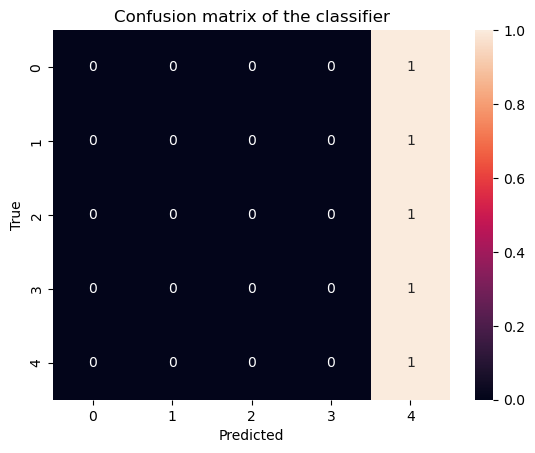

In [21]:
# Evaluate your model on the testing set
# Predict using the best model from RandomizedSearchCV
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [22]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)